# Introducción a librerías de DataScience en Python: Kmeans con Sklearn

En este curso haremos una revisión del algoritmo de kmeans y resolveremos un ejemplode clasificación de variables meteoceánicas utilizando la librería de Python Sklearn.

- [Accseso a datos](#Acceso-a-datos)
- [Exploración de datos](#Exploración-de-datos)
- [Método K Means](#Método-K-Means)
    - [Revisión del método](#Revisión-del-método)
    - [Aplicación del método con librerías de Python](#Aplicación-del-método-con-librerías-de-Python)
    - [Elección de k](#Elección-de-k)
        - [Método del codo](#Método-del-códo)
        - [Método de "silhouette coefficients"](#Método-de-"silhouette-coefficients")
- [Comparación de métodos](#Comparación-de-métodos)
    - [Método DBSCAN](#Método-DBSCAN)

# Acceso a datos

In [1]:
from pydap.cas.get_cookies import setup_session
from pydap.client import open_url
import xarray as xr

#Atlantic -Iberian Biscay Irish- Ocean Wave Reanalysis
url1 = "https://my.cmems-du.eu/thredds/dodsC/cmems_mod_ibi_wav_my_0.05deg-2D_PT1H-i"

#Atlantic-Iberian Biscay Irish- Ocean Physics Reanalysis
url2 = "https://my.cmems-du.eu/thredds/dodsC/cmems_mod_ibi_phy_my_0.083deg-2D_PT1H-m"

username = "***" 
password = "***"

In [2]:
#iniciar sesión
cas_url = "https://cmems-cas.cls.fr/cas/login"      
session = setup_session(cas_url, username, password)
session.cookies.set("CASTGC", session.cookies.get_dict()["CASTGC"]) 
#needed to keep the session alive, CAS: Central Authentication Service, TGC:Long Term Authentication

def data_access(url, username, password):
    print('Accediendo a los datos {}'.format(url[-9:]))
    data_store = xr.backends.PydapDataStore(open_url(url, session=session))
    ds = xr.open_dataset(data_store)
    print('Accediendo a datos finalizado')
    return ds

In [3]:
ds1=data_access(url1, username, password) 
ds2=data_access(url2, username, password) 

Accediendo a los datos 2D_PT1H-i
Accediendo a datos finalizado
Accediendo a los datos 2D_PT1H-m
Accediendo a datos finalizado


# Exploración de datos

In [4]:
print('Inside ds1:')
print('--------------------------------\n')
for var in ds1.variables:
    print(var,':',ds1[var].attrs['standard_name'],'\n')  

Inside ds1:
--------------------------------

latitude : latitude 

longitude : longitude 

VHM0 : sea_surface_wave_significant_height 

VHM0_SW1 : sea_surface_primary_swell_wave_significant_height 

VHM0_SW2 : sea_surface_secondary_swell_wave_significant_height 

VHM0_WW : sea_surface_wind_wave_significant_height 

VMDR : sea_surface_wave_from_direction 

VMDR_SW1 : sea_surface_primary_swell_wave_from_direction 

VMDR_SW2 : sea_surface_secondary_swell_wave_from_direction 

VMDR_WW : sea_surface_wind_wave_from_direction 

VPED : sea_surface_wave_from_direction_at_variance_spectral_density_maximum 

VSDX : sea_surface_wave_stokes_drift_x_velocity 

VSDY : sea_surface_wave_stokes_drift_y_velocity 

VTM01_SW1 : sea_surface_primary_swell_wave_mean_period 

VTM01_SW2 : sea_surface_secondary_swell_wave_mean_period 

VTM01_WW : sea_surface_wind_wave_mean_period 

VTM02 : sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment 

VTM10 : sea_surface_wave_mean_period_

In [5]:
print('Inside ds2:')
print('--------------------------------\n')
for var in ds2.variables:
    print(var,':',ds2[var].attrs['standard_name'],'\n')  

Inside ds2:
--------------------------------

longitude : longitude 

latitude : latitude 

time : time 

thetao : sea_water_potential_temperature 

ubar : barotropic_eastward_sea_water_velocity 

uo : eastward_sea_water_velocity 

vbar : barotropic_northward_sea_water_velocity 

vo : northward_sea_water_velocity 

zos : sea_surface_height_above_geoid 

mlotst : ocean_mixed_layer_thickness_defined_by_sigma_theta 



## Graficamos algunas de las variables

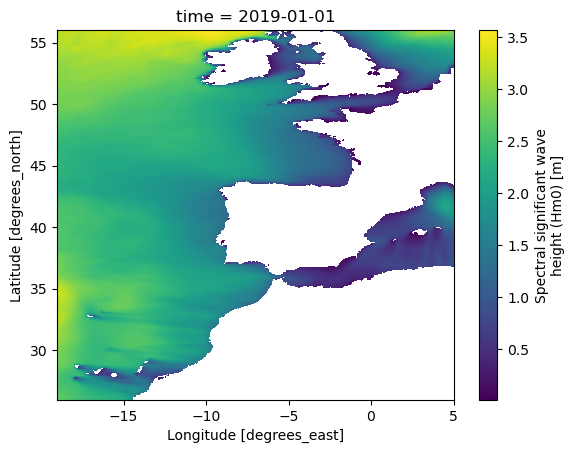

In [6]:
ds1.VHM0.loc['2019-01-01T00:00:00.000000000', :, :].plot() 

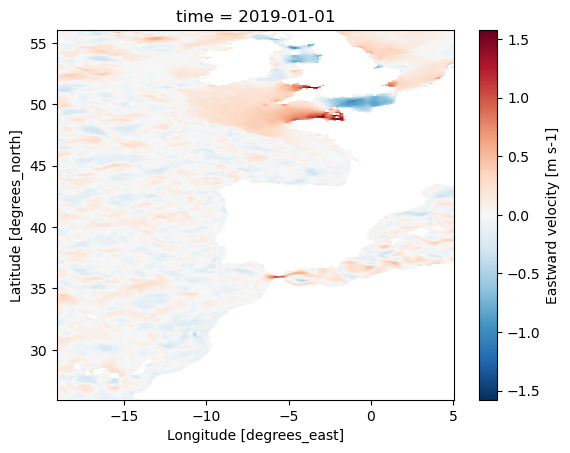

In [7]:
ds2.uo.interp(time=['2019-01-01T00:00:00.000000000'], method='linear').plot() 

# Método K Means

## Revisión del método

Completar ...

## Aplicación del método con librerías de Python

- Seleccionamos dos de las variables para hacer el clustering, en este caso HS y TP

In [8]:
lat = 30
long = -15

date_i='2019-01-01T00:00:00.000000000'
date_f='2019-03-01T00:00:00.000000000'
date_i2='2018-12-31T00:30:00.000000000'
date_f2='2019-03-01T00:30:00.000000000'

DIR = ds1.VMDR.loc[date_i:date_f, lat, long]
HS = ds1.VHM0.loc[date_i:date_f,  lat, long]
TP = ds1.VTM01_SW1.loc[date_i:date_f,  lat, long]
CVx = ds1.VSDX.loc[date_i:date_f,  lat, long]
CVy = ds1.VSDY.loc[date_i:date_f,  lat, long]

U = ds2.uo.loc[date_i2:date_f2,  lat, long]
V = ds2.vo.loc[date_i2:date_f2,  lat, long] 

U = U.interp(time=DIR.time.values[:], method='linear')
V = V.interp(time=DIR.time.values[:], method='linear')



In [9]:
print('DIR:',DIR.attrs['standard_name'])
print('HS:',HS.attrs['standard_name'])
print('TP:',TP.attrs['standard_name'])
print('U:',CVx.attrs['standard_name'])
print('V:',CVy.attrs['standard_name'])
# print('U:',U.attrs['standard_name'])
# print('V:',V.attrs['standard_name'])

DIR: sea_surface_wave_from_direction
HS: sea_surface_wave_significant_height
TP: sea_surface_primary_swell_wave_mean_period
U: sea_surface_wave_stokes_drift_x_velocity
V: sea_surface_wave_stokes_drift_y_velocity


- Utilizamos Seaborn para hacer pair plots

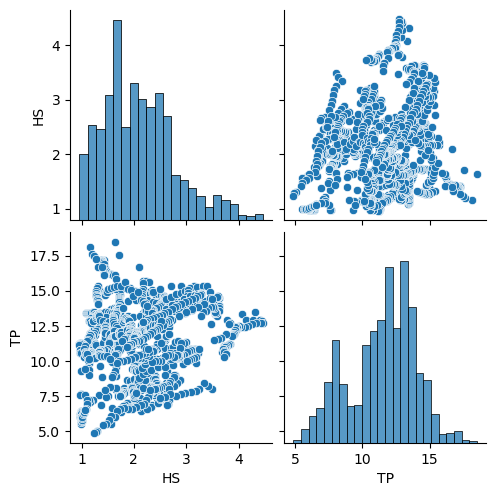

In [10]:
import seaborn as sns
import pandas as pd 

X=pd.DataFrame({'HS':HS,'TP':TP})
sns.pairplot(X)

- Utilizamos la librería sklearn para aplicar el Kmeans. Lo primero que tenemos que hacer es escalar los datos.

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

X=np.array([HS,TP]).T
scaler = StandardScaler()

X_s=scaler.fit_transform(X)

In [12]:
k = 3
k_means = KMeans(init="random",n_clusters=k,n_init=10)
k_means.fit(X_s)

centroides = scaler.inverse_transform(k_means.cluster_centers_)
etiquetas = k_means.labels_

# lowest SSE value
inertia=k_means.inertia_

# Number of iterations required to converge
niter=k_means.n_iter_

Graficamos los resultados:

Text(0, 0.5, 'TP')

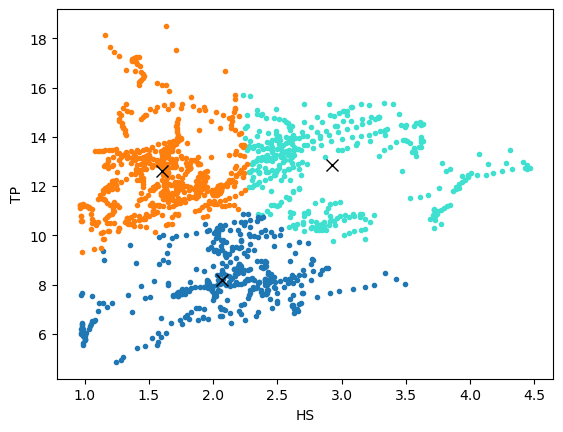

In [13]:
import matplotlib.pyplot as plt

plt.plot(X[etiquetas==0,0],X[etiquetas==0,1],'.',color='turquoise', label='cluster 1')
plt.plot(X[etiquetas==1,0],X[etiquetas==1,1],'.', color='tab:blue',label='cluster 2')
plt.plot(X[etiquetas==2,0],X[etiquetas==2,1],'.', color='tab:orange',label='cluster 2')

plt.plot(centroides[0,0],centroides[0,1],'kx',markersize=8, label='centroides')
plt.plot(centroides[1,0],centroides[1,1],'kx',markersize=8, label='centroides')
plt.plot(centroides[2,0],centroides[2,1],'kx',markersize=8, label='centroides')

plt.xlabel('HS')
plt.ylabel('TP')

- Podemos volver a hacer el pairs plot, esta vez con las clasificaciones. Referencia colores: [palettes](https://seaborn.pydata.org/tutorial/color_palettes.html)

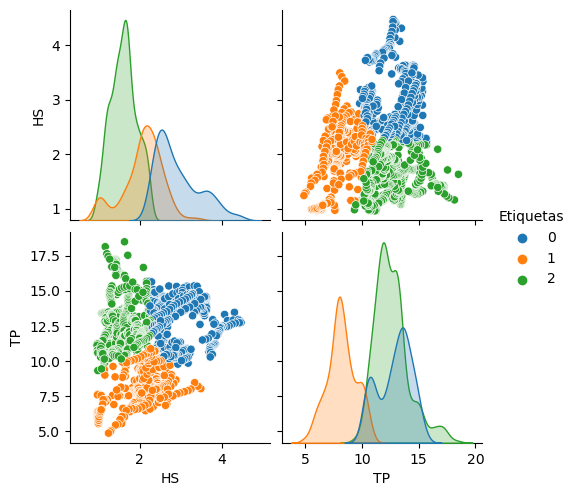

In [14]:
X_c=pd.DataFrame({'HS':HS,'TP':TP,'Etiquetas':etiquetas})

sns.pairplot(X_c,hue="Etiquetas",palette='tab10')

## Elección de k

### Método del códo

SSE: sum of square error

\begin{equation}
SSE = \sum_{i=1}^{n} (X_i-\bar{X})
\end{equation}

C:\Users\turlionear\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


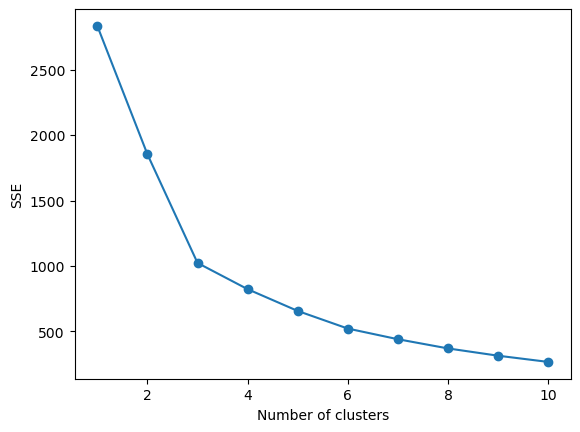

In [15]:
# calculate distortion for a range of number of cluster
distortions = []
silhouette_coefficients = []

for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_s)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

Podemos utilizar la librería kneed para encontrar el codo.

In [16]:
from kneed import KneeLocator, DataGenerator as dg 
kl = KneeLocator(
       range(1, 11), distortions, curve="convex", direction="decreasing"
       )

kl.elbow 

3

### Método de ["silhouette coefficients"](https://es.wikipedia.org/wiki/Silhouette_(clustering)) 

Distancia media de los puntos de un cluster a los puntos de los otros clasters:

\begin{equation}
a(i)=\frac{1}{|C_I|-1}\sum_{j \in C_I, i\neq j} d(i,j)
\end{equation}

Distancia mínima de los puntos dentro de un cluster:

\begin{equation}
b(i)= min\frac{1}{|C_k|}\sum_{j \in C_k} d(i,j), \ \ k\neq I
\end{equation}

La "silhpuette" para un punto i es:

\begin{equation}
s(i)= \frac{b(i)-a(i)}{max (b(i),a(i))}, \ \ si |C_I| > 1
\end{equation}

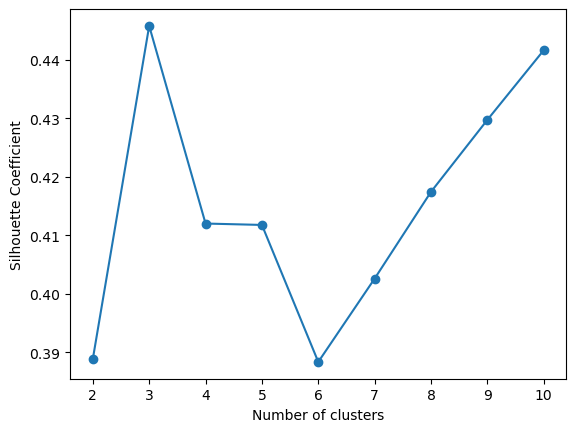

In [17]:
from sklearn.metrics import silhouette_score

silhouette_coefficients = []

for i in range(2, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_s)
    score = silhouette_score(X_s, km.labels_)
    
    silhouette_coefficients.append(score)

# plot
plt.plot(range(2, 11), silhouette_coefficients, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

# Comparación de métodos

## Método [DBSCAN](https://es.wikipedia.org/wiki/DBSCAN)

Revisión del método. Completar ...

In [18]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=2)
dbscan = DBSCAN(eps=0.3)

# Fit the algorithms to the features
kmeans.fit(X_s)
dbscan.fit(X_s)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
     X_s, kmeans.labels_
    ).round(2)
dbscan_silhouette = silhouette_score(
X_s, dbscan.labels_
    ).round (2)

In [19]:
kmeans_silhouette

0.39

In [20]:
dbscan_silhouette 

0.33